In [264]:
import numpy as np
import math

k_func = lambda x: np.exp(x)
q_func = lambda x: np.exp(x)
f_func = lambda x: np.sin(x)

betta1, nu1 = 0, 0 
betta2, nu2 = 1, 0
eps = 10 ** (-2)
N = 10
x = np.zeros(N + 1)
y = np.zeros(N + 1)
k = np.zeros(N + 1)
q = np.zeros(N + 1)
fi = np.zeros(N + 1)


# Метод прогонки
Для уравнения вида:
$\[
\frac{d}{dx}\left(k(x)\frac{du}{dx}\right) - q(x)u = -f(x)
\]$
вторая производная $\(\frac{d^2u}{dx^2}\)$ может быть аппроксимирована следующим образом:
$\[
\frac{d^2u}{dx^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}
\]$
Здесь $\(h\) $--- шаг сетки, $\(u_{i+1}, u_i, u_{i-1}\)$ --- значения функции $\(u(x)\)$ в сеточных точках $\(x_{i+1}, x_i, x_{i-1}\)$.

Коэффициенты $\(a, b, c\)$ для трехдиагональной матрицы задаются так:
$\[
a_j = \frac{k_{j-1} + k_j}{2h^2}, \quad b_j = \frac{k_{j+1} + k_j}{2h^2}, \quad c_j = \frac{k_{j+1} + 2k_j + k_{j-1}}{2h^2} + q_j
\]$
Эти коэффициенты формируют дискретное уравнение, которое аппроксимирует исходное дифференциальное уравнение на сетке. Система таких уравнений для всех сеточных точек затем решается с помощью метода прогонки.


In [265]:
def set_xkqfi(x, k, q, fi, N, m):
    h = 1.0 / N
    for j in range(N+1):
        x[j] = j * h
        if m == 0:
            fi[j] = math.sin(0.5)
            k[j] = math.exp(0.5)
        else:
            k[j] = math.exp(x[j])
            fi[j] = math.sin(x[j])
        q[j] = k[j]

# Применим функцию для инициализации массивов
set_xkqfi(x, k, q, fi, N, 1)
# print("x:", x)
# print("k:", k)
# print("q:", q)
# print("fi:", fi)



In [266]:
def sweep_method(y, k, fi, q, N):
    h = 1.0 / N
    alf = np.zeros(N + 1)
    bet = np.zeros(N + 1)
    a = np.zeros(N + 1)
    b = np.zeros(N + 1)
    c = np.zeros(N + 1)

    # Fill up the tridiagonal matrix
    for j in range(1, N):
        b[j] = (k[j + 1] + k[j]) / (2 * h ** 2)
        a[j] = (k[j - 1] + k[j]) / (2 * h ** 2)
        c[j] = (k[j + 1] + 2 * k[j] + k[j - 1]) / (2 * h ** 2) + q[j]
        

    # Standard boundary condition at x = 0
    # b[0] = k[0] / h + betta1
    # c[0] = -k[0] / h
    # bet[1] = nu1 / b[0]
    alf[1] = (k[0] + k[1])/(k[0] + k[1] + h * h * q[0])
    bet[1] = h * h * fi[0] / (k[0] + k[1] + h * h * q[0])
    # Forward sweep
    # alf[1] = c[0] / b[0]

    for j in range(1, N):
        alf[j + 1] = b[j] / (c[j] - a[j] * alf[j])
        bet[j + 1] = (fi[j] + a[j] * bet[j]) / (c[j] - a[j] * alf[j])

    # Standard boundary condition at x = 1
    # a[-1] = -k[-1] / h
    # b[-1] = k[-1] / h + betta2
    mu1 = 1 + 0.5 * h * q[N] + (k[N] + k[N - 1]) / (2 * h)
    hi2 = (k[N] + k[N - 1]) / (2 * h * mu1)
    # Backward substitution
    # y[N] = (nu2 + bet[N] * a[-1]) / (b[-1] - a[-1] * alf[N])
    y[N] = (0.5 * h * fi[N] / mu1 + hi2 * bet[N]) / (1 - hi2 * alf[N])
    for j in range(N - 1, -1, -1):
        y[j] = alf[j + 1] * y[j + 1] + bet[j + 1]
# Применим метод прогонки для нахождения y
sweep_method(y, k, fi, q, N)
# print("y:", y)


In [267]:
# # Удваиваем количество отрезков
# N_new = 2 * N 
# 
# # Инициализация новых массивов
# x_new = np.zeros(N_new + 1)
# y_new = np.zeros(N_new + 1)
# k_new = np.zeros(N_new + 1)
# q_new = np.zeros(N_new + 1)
# fi_new = np.zeros(N_new + 1)
# 
# # Заполнение новых массивов
# set_xkqfi(x_new, k_new, q_new, fi_new, N_new, 1)
# 
# # Применение метода прогонки для нового N
# sweep_method(y_new, k_new, fi_new, q_new, N_new)
# print("y_new:", y_new)
# print table of x y y_new



In [268]:
def max1(y, u, N, m):
    mx = 0
    if m == 0:
        for i in range(N):
            if mx < abs(u[i] - y[i]):
                mx = abs(u[i] - y[i])
    else:
        for i in range(N):
            if mx < abs(u[2 * i] - y[i]) / 3:
                mx = abs(u[2 * i] - y[i]) / 3
    return mx

In [269]:
current_error = 1.0 
y_cur = y
fix_N = N
while (current_error > eps):
    N_new = 2 * N
    x_new = np.zeros(N_new + 1)
    y_new = np.zeros(N_new + 1)
    k_new = np.zeros(N_new + 1)
    q_new = np.zeros(N_new + 1)
    fi_new = np.zeros(N_new + 1)
    set_xkqfi(x_new, k_new, q_new, fi_new, N_new, 1)
    sweep_method(y_new, k_new, fi_new, q_new, N_new)
    current_error = max1(y_cur, y_new, N, 1)
    print(f"N = {N}, error = {current_error}")
    N = N_new
    y_cur = y_new

print('')
print(f"y_N,        y_{N_new//fix_N}N")
for i in range(len(y)):
    print(f"{y[i]:.8f} {y_new[i]:.8f}")


N = 10, error = 0.0001679295933376864

y_N,        y_2N
0.17305436 0.17355815
0.17387640 0.17376967
0.17541392 0.17427856
0.17692631 0.17496725
0.17789577 0.17573532
0.17798311 0.17649781
0.17699046 0.17718367
0.17482975 0.17773434
0.17149634 0.17810238
0.16704718 0.17825033
0.16158276 0.17814951


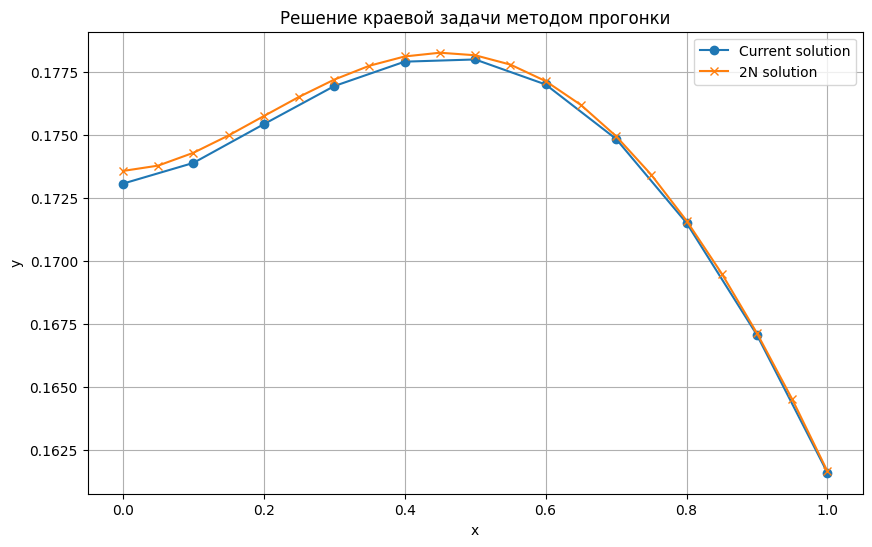

In [270]:
import matplotlib.pyplot as plt
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', label = "Current solution")
plt.plot(x_new, y_new, marker='x', label = f"{N_new//fix_N}N solution")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Решение краевой задачи методом прогонки")
plt.legend()
plt.grid(True)
plt.show()


Error between model and current solution 0.033689935808141086


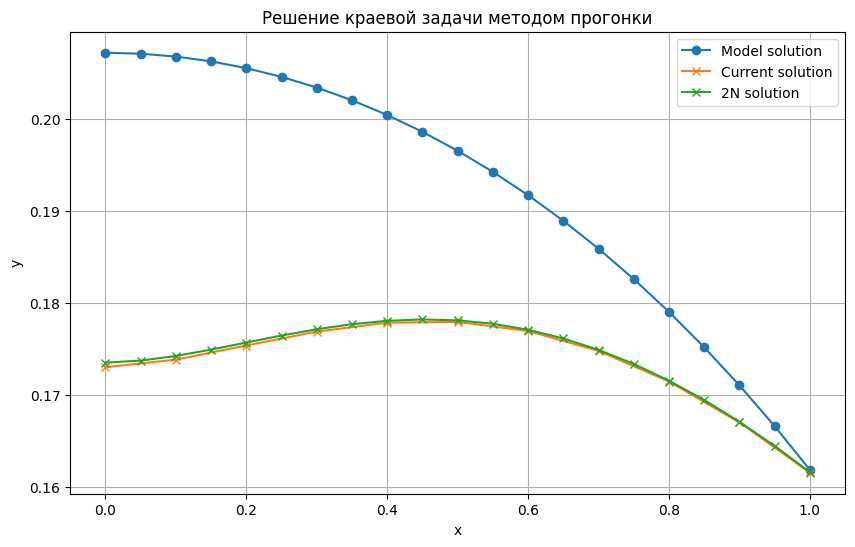

In [271]:
N_model = N 
x_model = np.zeros(N_model + 1)
y_model = np.zeros(N_model + 1)
k_model = np.zeros(N_model + 1)
q_model = np.zeros(N_model + 1)
fi_model = np.zeros(N_model + 1)

set_xkqfi(x_model, k_model, q_model, fi_model, N_model, 0)
sweep_method(y_model, k_model, fi_model, q_model, N_model)

# error between model and not model
print("Error between model and current solution", max1(y_model, y_new, N_model, 0))

# now we have to plot model, N and 2N solutions
plt.figure(figsize=(10, 6))
plt.plot(x_model, y_model, marker='o', label = "Model solution")
plt.plot(x, y, marker='x', label = "Current solution")
plt.plot(x_new, y_new, marker='x', label = f"{N_new//fix_N}N solution")


plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.title("Решение краевой задачи методом прогонки")
plt.show()


# Сравнение аналитического и численного решения модельной задачи

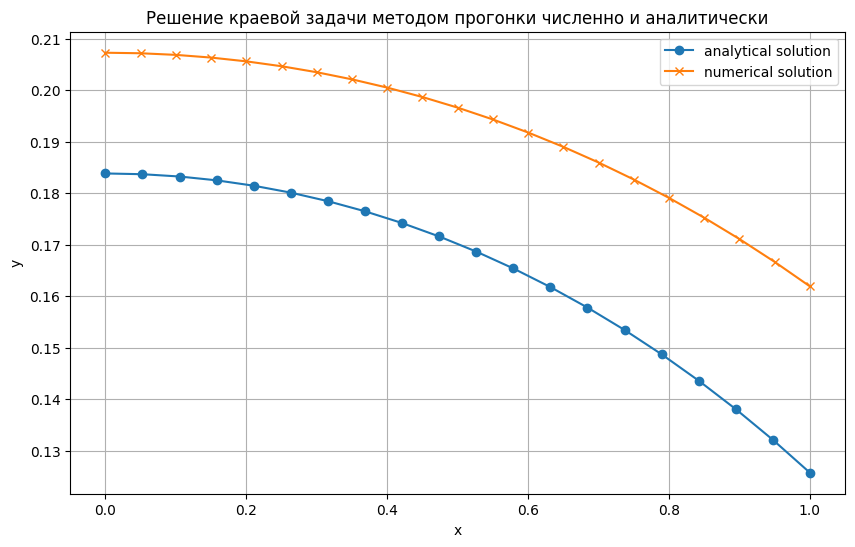

In [272]:
# model analytical solve 
# def solve_func(x):
#     return (-0.053487 *(np.exp(x) + np.exp(-x)) + 0.290787)

def solve_func(x_test):
    t = np.sin(0.5)/np.exp(0.5)
    constants = (-1) * t / (2 *(np.exp(1)))
    return (constants * (np.exp(x_test) + np.exp(-x_test)) + t)

# plot for it 
x = np.linspace(0, 1, N_model)
y = solve_func(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f"analytical solution", marker='o')
plt.plot(x_model, y_model, marker ='x', label = f"numerical solution")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Решение краевой задачи методом прогонки численно и аналитически")

plt.legend()
plt.grid(True)
plt.show()  



In [273]:
# difference between model and analytical
print("Error between model and analytical solution", max1(y_model, y, N_model, 0))

Error between model and analytical solution 0.04092245512230433


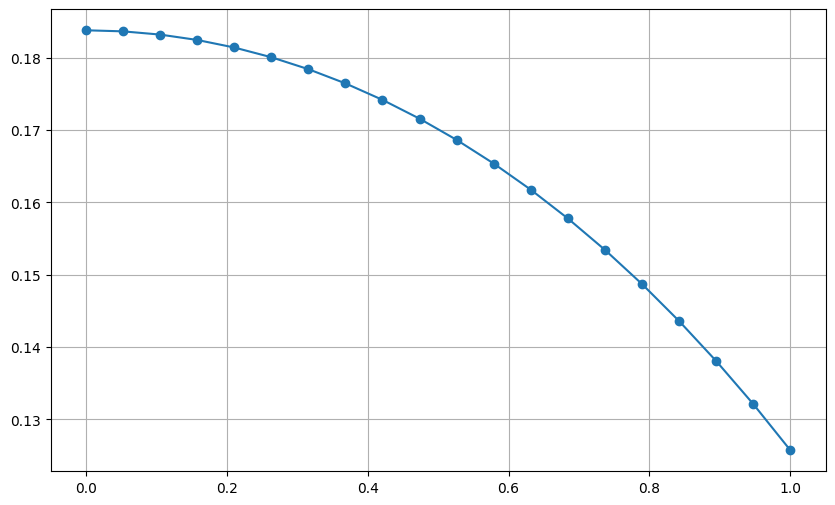

In [274]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', label = "analytical solution")
plt.grid()
plt.show()

# Сравнение аналитического и численного решения тестовой задачи 

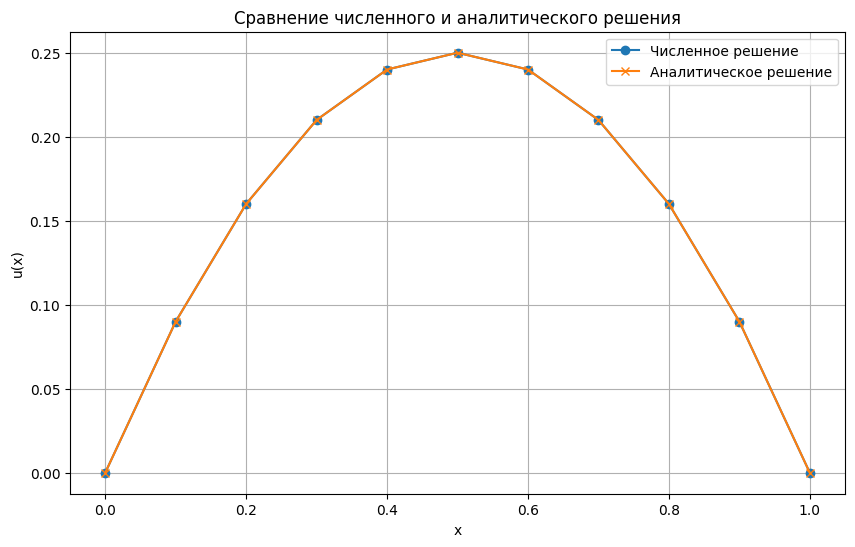

In [275]:
# Повторное выполнение кода для решения простого дифференциального уравнения

import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи и функции
N = 10  # количество узлов
x = np.linspace(0, 1, N+1)  # координаты узлов
h = 1.0 / N  # шаг сетки

# Инициализация массивов
y = np.zeros(N + 1)
k = np.ones(N + 1)  # k(x) = 1
q = np.zeros(N + 1)  # q(x) = 0
fi = np.full(N + 1, 2)  # f(x) = -2

# Аналитическое решение
u_analytical = -x**2 + x

# Функция для метода прогонки
def sweep_method_test(y, k, fi, q, N):
    h = 1.0 / N
    alf = np.zeros(N + 2)
    bet = np.zeros(N + 2)
    a = np.zeros(N + 2)
    b = np.zeros(N + 2)
    c = np.zeros(N + 2)
    
    for j in range(1, N):
        b[j] = (k[j + 1] + k[j]) / (2 * h ** 2)
        a[j] = (k[j - 1] + k[j]) / (2 * h ** 2)
        c[j] = (k[j + 1] + 2 * k[j] + k[j - 1]) / (2 * h ** 2) + q[j]

    # Forward sweep
    alf[1] = 0
    bet[1] = 0

    for j in range(1, N):
        alf[j+1] = b[j] / (c[j] - a[j] * alf[j])
        bet[j+1] = (fi[j] + a[j] * bet[j]) / (c[j] - a[j] * alf[j])

    # Backward substitution
    y[N] = 0

    for j in range(N-1, -1, -1):
        y[j] = alf[j+1] * y[j+1] + bet[j+1]

# Применяем метод прогонки
sweep_method_test(y, k, fi, q, N)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', label='Численное решение')
plt.plot(x, u_analytical, marker='x', label='Аналитическое решение')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Сравнение численного и аналитического решения")
plt.legend()
plt.grid(True)
plt.show()


In [276]:
k_func = lambda x: (x**2 + 1)
q_func = lambda x: x
f_func = lambda x: np.exp(-x)

betta1, nu1 = 0, 0 
betta2, nu2 = 1, 0
eps = 10 ** (-7)
N = 10
x = np.zeros(N + 1)
y = np.zeros(N + 1)
k = np.zeros(N + 1)
q = np.zeros(N + 1)
fi = np.zeros(N + 1)

def set_xkqfi(x, k, q, fi, N, m):
    h = 1.0 / N
    for j in range(N+1):
        x[j] = j * h
        if m == 0:
            fi[j] = math.exp(-0.5)
            k[j] = k_func(0.5)
            q[j] = q_func(0.5)
        else:
            k[j] = k_func(x[j])
            fi[j] = f_func(x[j])
            q[j] = q_func(x[j])
# Применим функцию для инициализации массивов
set_xkqfi(x, k, q, fi, N, 1)

In [277]:
sweep_method(y, k, fi, q, N)
current_error = 1.0
y_cur = y
fix_N = N
while(current_error > eps):
    N_new = 2 * N
    x_new = np.zeros(N_new + 1)
    y_new = np.zeros(N_new + 1)
    k_new = np.zeros(N_new + 1)
    q_new = np.zeros(N_new + 1)
    fi_new = np.zeros(N_new + 1)
    set_xkqfi(x_new, k_new, q_new, fi_new, N_new, 1)
    sweep_method(y_new, k_new, fi_new, q_new, N_new)
    current_error = max1(y_cur, y_new, N, 1)
    print(f"N = {N}, error = {current_error}")
    N= N_new
    y_cur = y_new
print('')
print(f"y_N,        y_{N_new//fix_N}N")
for i in range(len(y)):
    print(f"{y[i]:.8f} {y_new[i]:.8f}")


N = 10, error = 0.0004768303097881417
N = 20, error = 0.00011916680947006893
N = 40, error = 2.9789158132083788e-05
N = 80, error = 7.447130334366688e-06
N = 160, error = 1.8617734956668148e-06
N = 320, error = 4.654427200693571e-07
N = 640, error = 1.1636159091832354e-07
N = 1280, error = 2.9081938301978028e-08

y_N,        y_256N
0.60248151 0.60057440
0.59750639 0.60057432
0.58438359 0.60057409
0.56516349 0.60057371
0.54189051 0.60057318
0.51639861 0.60057249
0.49019091 0.60057165
0.46440282 0.60057066
0.43982579 0.60056952
0.41696333 0.60056823
0.39609679 0.60056678


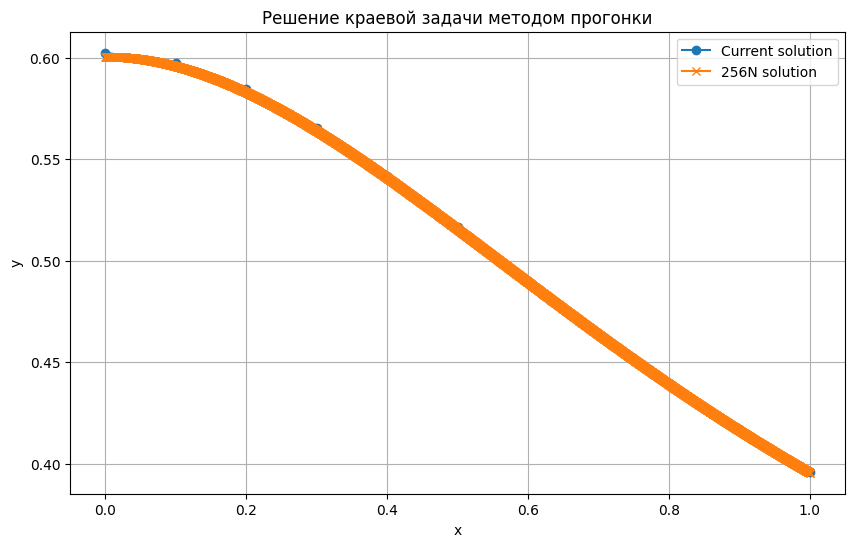

In [278]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', label = "Current solution")
plt.plot(x_new, y_new, marker='x', label = f"{N_new//fix_N}N solution")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Решение краевой задачи методом прогонки")
plt.legend()
plt.grid(True)
plt.show()

Error between model and current solution 0.08436934719735067


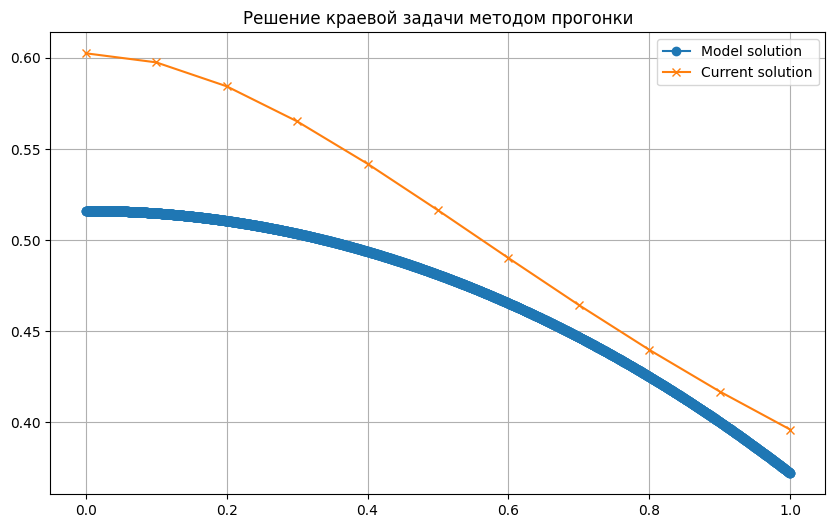

In [279]:
N_model = N
x_model = np.zeros(N_model + 1)
y_model = np.zeros(N_model + 1)
k_model = np.zeros(N_model + 1)
q_model = np.zeros(N_model + 1)
fi_model = np.zeros(N_model + 1)
set_xkqfi(x_model, k_model, q_model, fi_model, N_model, 0)
sweep_method(y_model, k_model, fi_model, q_model, N_model)

print("Error between model and current solution", max1(y_model, y_new, N_model, 0))
plt.figure(figsize=(10, 6))
plt.plot(x_model, y_model, marker='o', label = "Model solution")
plt.plot(x, y, marker='x', label = "Current solution")
plt.legend()
plt.grid()
plt.title("Решение краевой задачи методом прогонки")
plt.show()


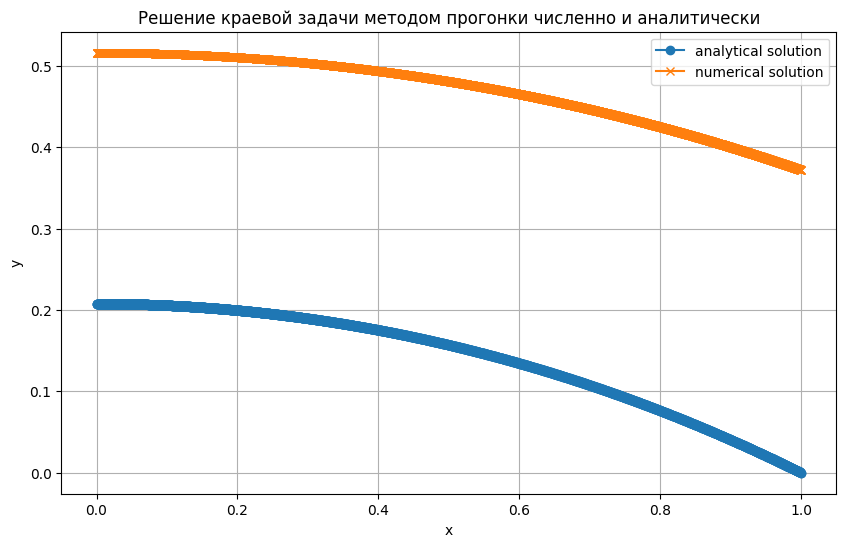

In [280]:
import math
def solve_func2(x_test):
    constants = (-2 / math.sqrt(np.exp(1))) / (np.exp(math.sqrt(10) / 5) + np.exp(-math.sqrt(10) / 5))
    right = 2 / math.sqrt(np.exp(1))
    return constants * (np.exp(math.sqrt(10)/5 * x_test) + np.exp(-math.sqrt(10)/5 * x_test)) + right

x = np.linspace(0, 1, N_model)
y = solve_func2(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f"analytical solution", marker='o')
plt.plot(x_model, y_model, marker ='x', label = f"numerical solution")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Решение краевой задачи методом прогонки численно и аналитически")

plt.legend()
plt.grid(True)
plt.show()


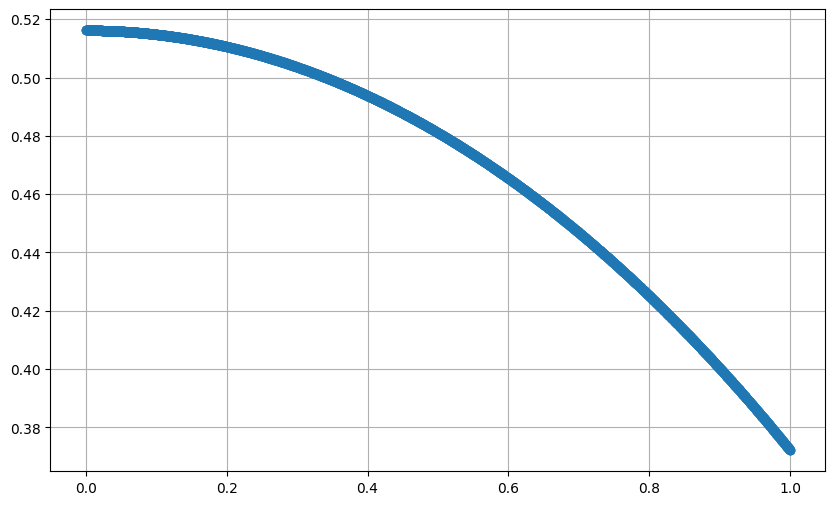

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(x_model, y_model, marker='o', label = "Model solution")
plt.grid()
plt.show()

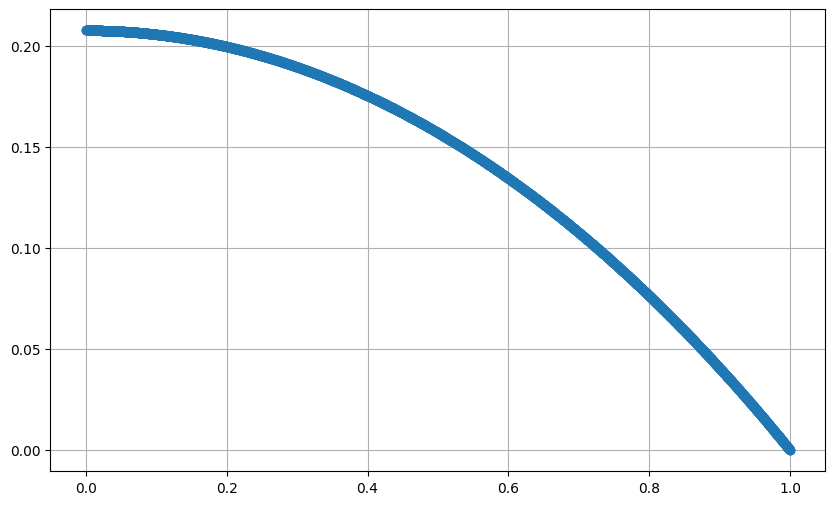

In [282]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', label = "Model solution")
plt.grid()
plt.show()